 # DL기반 시계열 모델링

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten, GlobalMaxPool1D
from keras.optimizers import Adam

import joblib

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### 3) 시계열분해 plot

In [4]:
def decomp_plot(decomp) :
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')
    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

### 4) 2차원 --> 3차원 변환(for LSTM, CNN)

In [5]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)

### 5) 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

In [6]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

## (3) 데이터 불러오기

* 31번 파일에서 저장한 데이터를 로딩합니다.

In [7]:
data2 = joblib.load('data2.pkl')

# 2.전처리1

## (1) 데이터 분할

### 1) x, y 나누기

* .values(넘파이 어레이)로 변환해서 저장하는 이유 ➡ 데이터 스플릿 index를 적용해서 데이터를 가져오기 위해서

In [8]:
target = 'y'

x = data2.drop([target, 'Datetime'], axis = 1)
y = data2.loc[:, target]

### 2) 시계열 데이터 분할

In [9]:
val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

## (2) 스케일링

In [10]:
# x
scaler_x = MinMaxScaler() # 0 ~ 1
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

In [11]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

# 3.모델링1 : DNN

## (1) 학습 및 예측

* 설계

In [12]:
x_train_s2.shape

(1150, 12)

In [13]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(16, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

* 학습

In [ ]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

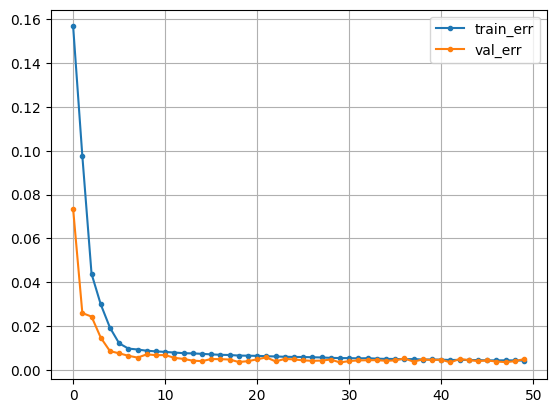

In [15]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [16]:
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 0s 2ms/step


## (2) 평가

### 1) 검증성능

In [17]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 204.88725271679107
MAPE: 0.22294426722087174
R2  : 0.6287533919231663


### 2) 결과 시각화

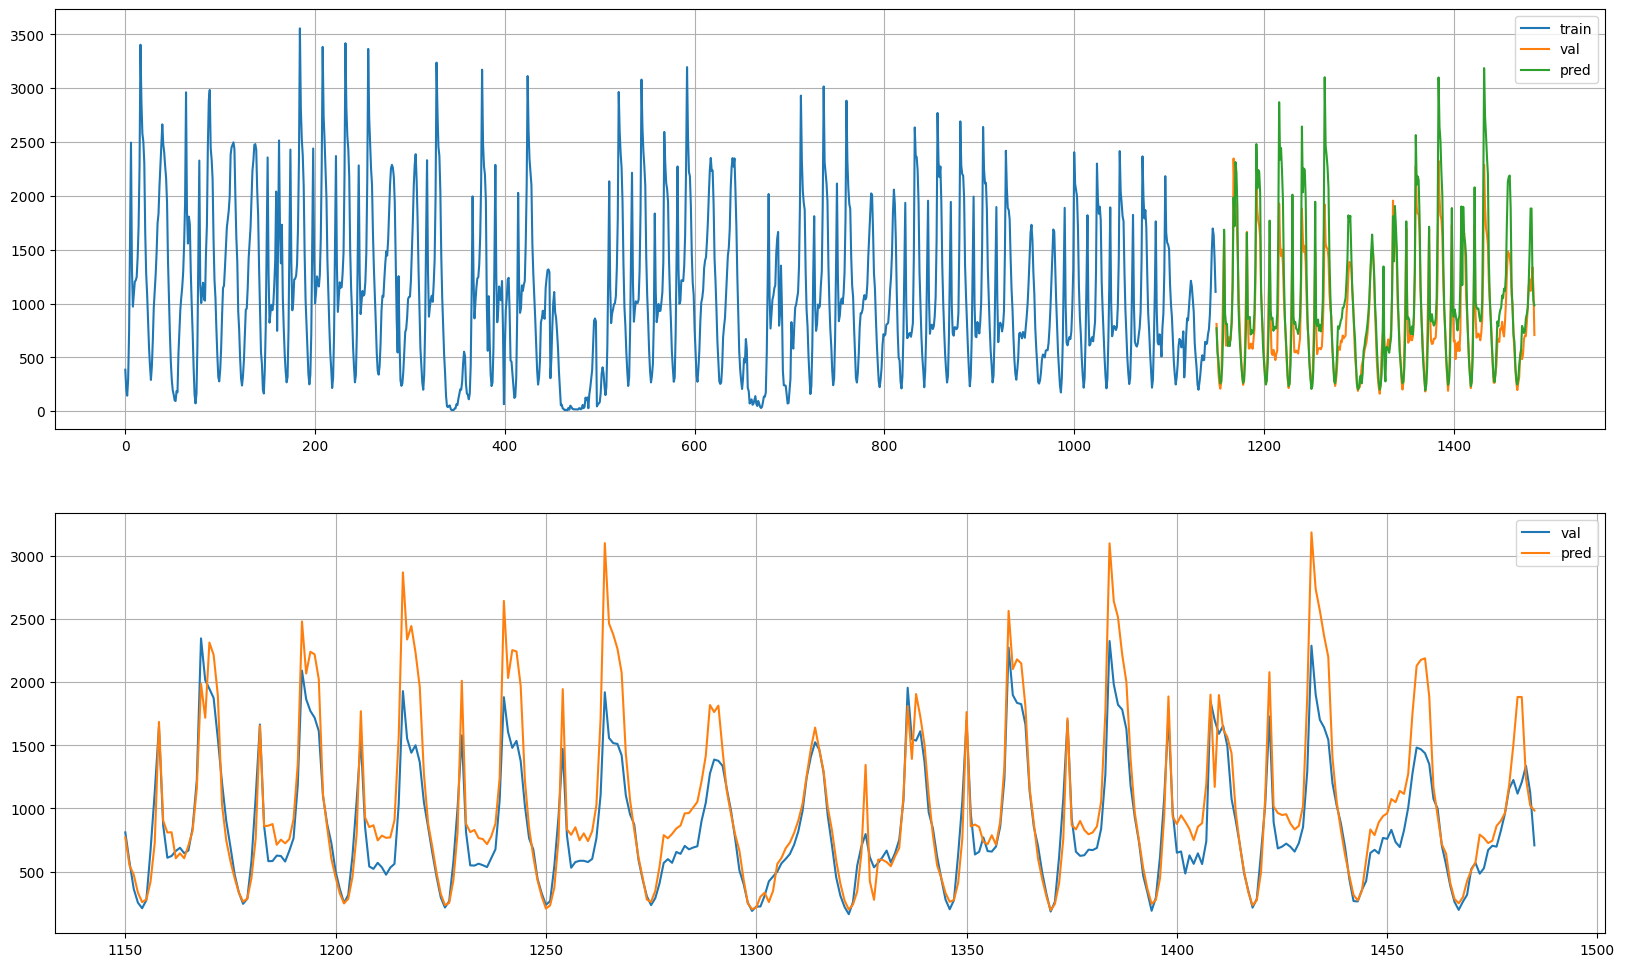

In [18]:
plot_model_result(y_train, y_val, pred)

# 4.전처리2

## (1) 3차원 구조로 만들기

In [19]:
timesteps = 24
x2, y2 = temporalize(x, y, timesteps)

In [20]:
x2.shape

(1463, 24, 12)

## (2) 시계열 데이터 분할

In [21]:
val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

In [22]:
x_train.shape, x_val.shape

((1127, 24, 12), (336, 24, 12))

# 5.모델링2 : LSTM

## (1) 3차원 데이터셋 전처리 : 스케일링

In [23]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스케일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

In [24]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

## (2) 학습 및 예측

* 설계

In [25]:
n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([
            LSTM(32, input_shape = (timesteps, n_features), return_sequences = True),
            LSTM(16, return_sequences = True),
            LSTM(8),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

* 학습

In [26]:
x_train_s3.shape, y_train_s3.shape

((1127, 24, 12), (1127, 1))

In [27]:
hist = model2.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
29/29 [==============================] - 9s 86ms/step - loss: 0.0488 - val_loss: 0.0187
Epoch 2/30
29/29 [==============================] - 1s 37ms/step - loss: 0.0218 - val_loss: 0.0198
Epoch 3/30
29/29 [==============================] - 1s 36ms/step - loss: 0.0163 - val_loss: 0.0109
Epoch 4/30
29/29 [==============================] - 1s 37ms/step - loss: 0.0133 - val_loss: 0.0113
Epoch 5/30
29/29 [==============================] - 1s 37ms/step - loss: 0.0145 - val_loss: 0.0168
Epoch 6/30
29/29 [==============================] - 1s 36ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 7/30
29/29 [==============================] - 1s 37ms/step - loss: 0.0095 - val_loss: 0.0073
Epoch 8/30
29/29 [==============================] - 1s 37ms/step - loss: 0.0083 - val_loss: 0.0110
Epoch 9/30
29/29 [==============================] - 1s 48ms/step - loss: 0.0079 - val_loss: 0.0243
Epoch 10/30
29/29 [==============================] - 2s 58ms/step - loss: 0.0116 - val_loss: 0.0167
Epoch 11/

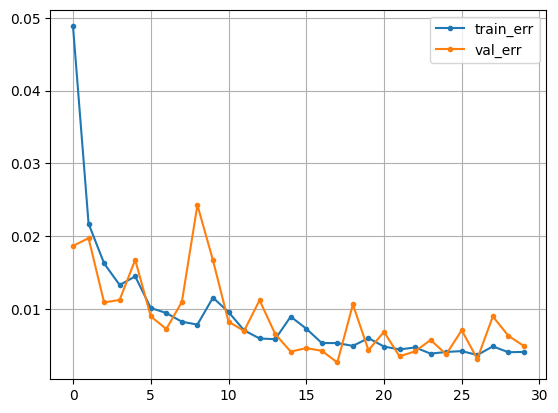

In [28]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [29]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 1s 9ms/step


## (3) 평가

### 1) 검증성능

In [30]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 193.86300282251267
MAPE: 0.22641746169888247
R2  : 0.7231014463425682


### 2) 결과 시각화

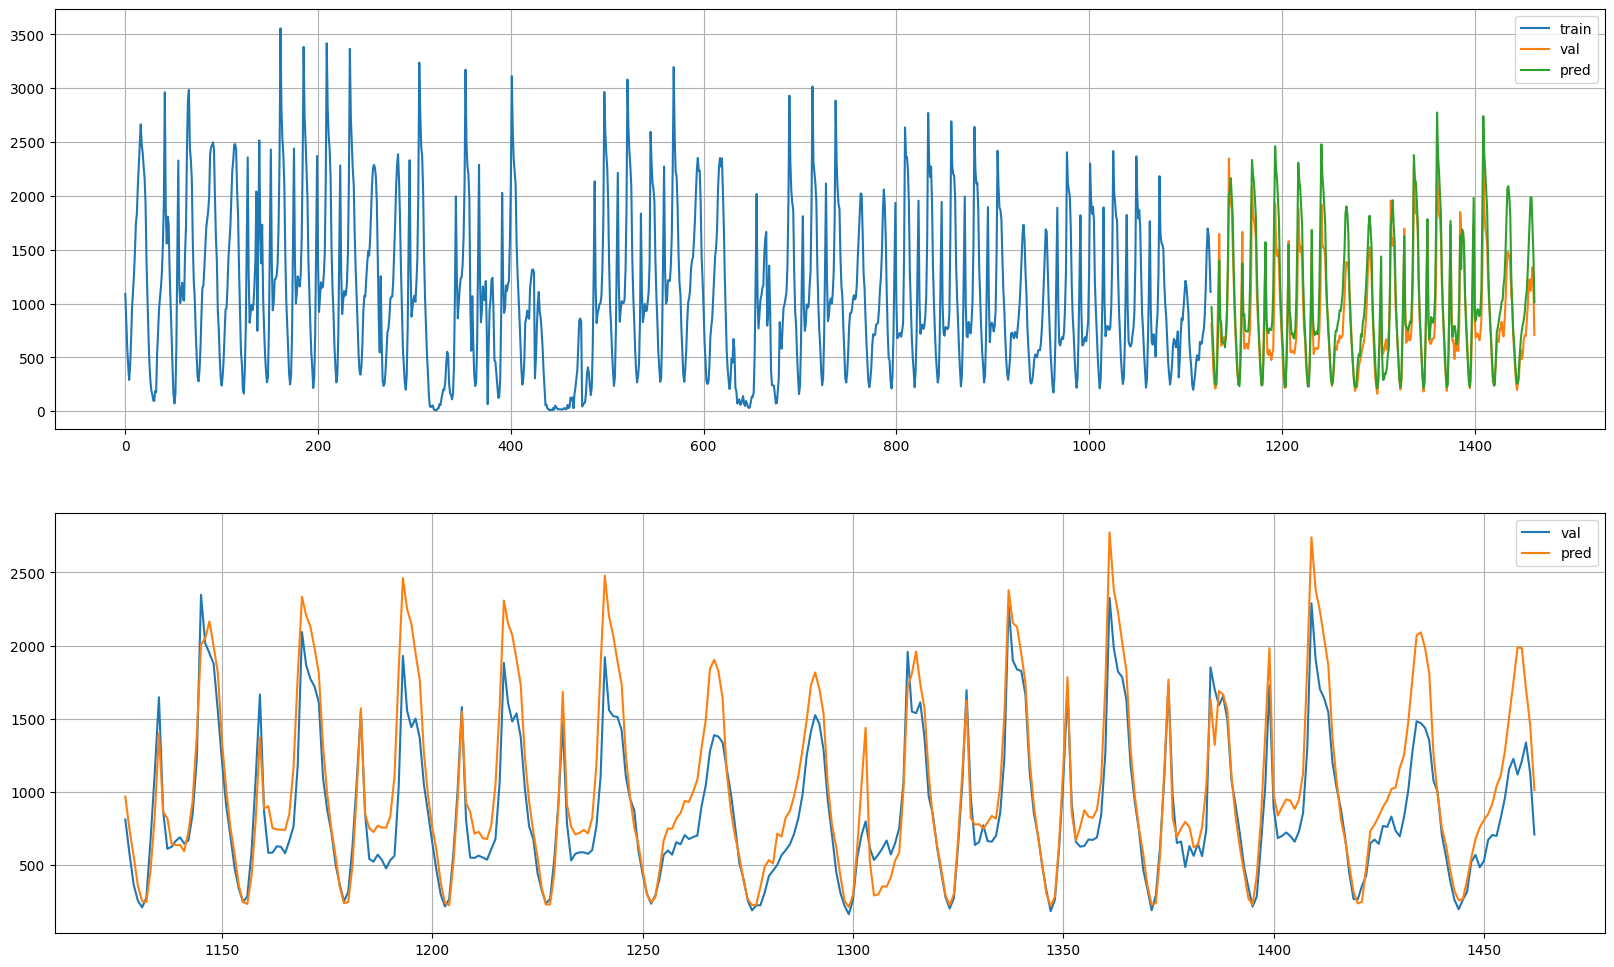

In [31]:
plot_model_result(y_train, y_val, pred)

# 6.모델링3 : CNN

## (1) 학습 및 예측

* 설계

In [ ]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([
            Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
            Conv1D(16, 5, activation='relu', padding = 'same'),
            Flatten(),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

* 학습

In [ ]:
x_train_s3.shape, y_train_s3.shape

In [ ]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [ ]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

## (2) 평가

### 1) 검증성능

In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

### 2) 결과 시각화

In [ ]:
plot_model_result(y_train, y_val, pred)